Plotting a UnitIntervalMesh:


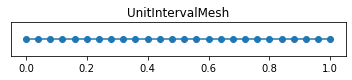

In [1]:
from dolfin import *
import numpy as np
parameters["form_compiler"]["representation"] = 'quadrature'
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)
import matplotlib.pyplot as plt

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

# Define mesh
N_mesh = 25
mesh = UnitIntervalMesh(N_mesh)
#mesh = RectangleMesh(Point(0., 0.), Point(1., 0.1), 50, 5)

print("Plotting a UnitIntervalMesh:")
plt.figure()
plot(mesh, title="UnitIntervalMesh")

tol = 1E-12
# Sub domain for clamp at left end
def left(x, on_boundary):
    return near(x[0], 0.,tol) and on_boundary

# Sub domain for rotation at right end
def right(x, on_boundary):
    return near(x[0], 1.,tol) and on_boundary

def left_and_right(x, on_boundary):
    return on_boundary

# Set up boundary domains

In [2]:
# Create mesh function over the cell facets
boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary_subdomains.set_all(0)
force_boundary = AutoSubDomain(right)
force_boundary.mark(boundary_subdomains, 3)

# Define measure for boundary condition integral
dss = ds(subdomain_data=boundary_subdomains)

In [3]:
E = Constant(70e3)
nu = Constant(0.3)
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu)
sig0 = Constant((1e1))  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus
rho = Constant(10e4)

Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 500
load_steps = np.linspace(0, 1, Nincr+1)[1:]

dt = Constant(load_steps[1]-load_steps[0])
dt_ = float(dt)

# Newmark-beta method
betaN = Constant(0.25)
gammaN = Constant(0.5)

In [4]:
float(mu), float(dt), float(sqrt(2*mu/rho))

(26923.076923076922, 0.002, 0.7337993857053428)

In [5]:
deg_u = 2
deg_stress = 2
V = FunctionSpace(mesh, "CG", deg_u)
We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=1, quad_scheme='default')
W = FunctionSpace(mesh, We)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e)
# Define function space for stresses
Vsig = VectorFunctionSpace(mesh, "DG", 0)

In [6]:
sig = Function(W)
sig_old = Function(W)
beta = Function(W0)
beta1 = Function(V)
gamma0 = Function(W0)
gamma0.interpolate(Constant(1e-6))
u = Function(V, name="Total displacement")
u_pre = Function(V)
u_old = Function(V)
u_d_old = Function(V)
u_dd_old = Function(V)
du = Function(V, name="Iteration correction")
Du = Function(V, name="Current increment")
v = TrialFunction(V)
u_ = TestFunction(V)

sig_out = Function(Vsig, name="sigma")
eps_out = Function(Vsig, name="epsilon")

In [7]:
# Set up boundary condition at left end
# bc_expression = Expression( ("t <= tc ? x[0]*1e-6*pow(t,1) : x[0]*0.5e-6"), tc=0.5, t=0, degree=2) # Constant(0.0)
# t*x[0]*(1-t*x[0]/L)/L -BC1
# t*x[0]*(1-t*x[0]*x[0]/L)/L -BC2
# "t*t*x[0]*(1-x[0]*x[0]/L)/L" - 0 BC
bc_expression = Expression(("t*x[0]*(1-t*x[0]*x[0]/L)/L"), L=1, t=0, degree=2)
bc = DirichletBC(V, bc_expression, left_and_right)

zero = Constant(0.0)
bc_newton = DirichletBC(V, zero, left_and_right)

# bc = [DirichletBC(V.sub(1), 0, facets, 1), DirichletBC(V.sub(0), 0, facets, 3)]
n = FacetNormal(mesh)

q_lim = float(2/sqrt(3)*sig0*mu*2)
# loading = Expression("q*t", q=q_lim, t=0, degree=2)
loading = Expression(("t <= tc ? q*t*(1-t)*4 : 0"), q=0.2*q_lim, t=0, tc=0.7, degree=2)

# DEFINING SOURCE TERM
# source = Expression(("t <= tc && x[0]<0.55 && x[0]>0.45  ? q*t*(1-t)*4 : 0"), q=0.2*q_lim, t=0, tc=1.2, degree=2)
# source = Constant(0.0)

# MMS - Nonlinear
# "(2*eps0*eps0*(G0*t*t-rho*x[0]*x[0])*pow(L,4)-4*pow(L,3)*eps0*rho*t*x[0]*x[0]+8*t*t*(eps0*x[0]-1/4)*rho*pow(x[0],2)*L*L+8*L*rho*pow(t,3)*pow(x[0],3)-8*rho*pow(t,4)*pow(x[0],4))/(L*L*pow(L*L*eps0-2*t*t*x[0]+L*t,2))"

# MMS - linear
# (2*G0*t*t-2*rho*x[0]*x[0])/L/L - BC1
# 6*x[0]*(G0*t*t-(1/3)*rho*x[0]*x[0])/L/L - BC2
# (2*(rho*(-x[0]*x[0]+L)+3*G0*t*t))*x[0]/L/L - 0 BC case

source = Expression(\
    ("6*x[0]*(G0*t*t-(1/3)*rho*x[0]*x[0])/L/L")\
    ,G0=float(mu), rho=float(rho), t=0, L=1, degree=2)

# (2*eps0*eps0*(G0*t*t-rho*x*x)*pow(L,4)
#  -4*pow(L,3)*eps0*rho*t*x*x
#  +8*x*x*t*t*rho*(x*eps0-1/4)*L*L
#  +8*L*rho*pow(t,3)*pow(x,3)
#  -8*rho*pow(t,4)*pow(x,4)
# )
# /(L*L*pow(L*L*eps0-2*t*2*x+L*t,2))


def F_ext(v):
    return dot(loading,v)*dss(3)
    # return loading*dot(n, v)*dss(3)

In [8]:
# Update formula for acceleration
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
def update_a(u, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        betaN_ = betaN
    else:
        dt_ = float(dt)
        betaN_ = float(betaN)
    return (u-u_old-dt_*v_old)/betaN_/dt_**2 - (1-2*betaN_)/2/betaN_*a_old

# Update formula for velocity
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
def update_v(a, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        gamma_ = gammaN
    else:
        dt_ = float(dt)
        gamma_ = float(gammaN)
    return v_old + dt_*((1-gamma_)*a_old + gamma_*a)

def update_fields(u, u_old, v_old, a_old):
    """Update fields at the end of each time step."""

    # Get vectors (references)
    u_vec, u0_vec  = u.vector(), u_old.vector()
    v0_vec, a0_vec = v_old.vector(), a_old.vector()

    # use update functions using vector arguments
    a_vec = update_a(u_vec, u0_vec, v0_vec, a0_vec, ufl=False)
    v_vec = update_v(a_vec, u0_vec, v0_vec, a0_vec, ufl=False)

    # Update (u_old <- u)
    v_old.vector()[:], a_old.vector()[:] = v_vec, a_vec
    u_old.vector()[:] = u.vector()

In [9]:
def eps(v):
    e = 0.5*grad(v)
    return e

def sigma(eps_el):
    return 2*mu*eps_el

def sigma_out(r):
    return 2.0*mu*sym(grad(r))

In [10]:
def proj_sig(old_u,old_sig,old_Du):
    eps_old = eps(old_u)
    beta = sig0/(abs(eps_old[0])+sig0)
    beta = 1
    # beta = gamma0
    # beta /= (eps_old[0]+as_tensor(gamma0[0]))
    return 2*mu*beta*eps(old_Du)+old_sig, beta


In [11]:
def sigma_tang(e):
    return 2*mu*beta*e

In [12]:
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
dxm = dx(metadata=metadata)

# a_Newton = inner(eps(v), sigma_tang(eps(u_)))*dxm

# a_Newton = inner(eps(u_), sigma_tang(eps(v)))*dxm

a_Newton = rho*inner(u_,v)/(betaN*dt*dt)*dxm + inner(2*eps(u_), sigma_tang(eps(v)) )*dxm
# F_ext(u_) + \
res = (-rho)*inner(u_,u)/(betaN*dt*dt)*dxm + \
      -inner(2*eps(u_), sig)*dxm + \
      inner(u_,source)*dxm + \
      rho*inner(u_old+dt*u_d_old,u_)*1./(betaN*dt*dt)*dxm + \
      (1.-2*betaN)/(2*betaN)*rho*inner(u_dd_old,u_)*dxm

In [13]:
def local_project(v, V, u=None):
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dxm
    b_proj = inner(v, v_)*dxm
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [14]:
file_results = XDMFFile("nonlinearElas1DVeri__results.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

In [15]:
sig_out.ufl_shape

(1,)

In [16]:
results = np.zeros((Nincr+1, 5))
results_1d = np.zeros((Nincr+1, N_mesh))

# Initial conditions
u_old.interpolate( Expression(("0"), degree=2) )
u_d_old.interpolate( Expression(("0"), degree=2) )
# u.assign(u_old)

for (i, t) in enumerate(load_steps):
    loading.t = t
    bc_expression.t = t
    source.t = t
    
    u_pre.assign(u)
    
    # Prepare for U_n+1^0 from U_n
    bc.apply(u.vector())
    print('U at the left and right',u(0), " ", u(1))
    print('Source at the left and right',source(0), " ", source(1))
    # -- Compute components in F(U_n+1^0)
    Du.assign(u-u_pre)
    sig_, beta_ = proj_sig(u_pre,sig_old,Du)
    local_project(sig_, W, sig)
    local_project(beta_, W0, beta)
    A, Res = assemble_system(a_Newton, res, bc_newton)
    
    nRes0 = Res.norm("l2")
    nRes = nRes0
    print("Increment:", str(i+1),"   Initial Residual:", nRes0)
    niter = 0
    
    while (nRes/nRes0 > tol and nRes0>1e-10) and niter < Nitermax:
        solve(A, du.vector(), Res, "mumps")
        Du.assign(Du+du)
        u.assign(u+du) # u^{k+1}_{n+1}
        sig_, beta_ = proj_sig(u_pre,sig_old,Du)
        local_project(sig_, W, sig)
        local_project(beta_, W0, beta)
        A, Res = assemble_system(a_Newton, res, bc_newton)
        nRes = Res.norm("l2")
        print("    Residual:", nRes," ",niter)
        niter += 1
    u.assign(u_pre+Du)
    
    update_fields(u, u_old, u_d_old, u_dd_old)
    
    sig_old.assign(sig)
    
# ----------------
# Post-processing
# ----------------
#
# Inside the incremental loop, the displacement and plastic strains are exported
# at each time increment, the plastic strain must first be projected onto the
# previously defined DG FunctionSpace. We also monitor the value of the cylinder
# displacement on the inner boundary. The load-displacement curve is then plotted::

    local_project(sig, Vsig, sig_out)
    local_project(eps(u), Vsig, eps_out)
    
    file_results.write(u, t)
    for i_x in range(N_mesh):
        results_1d[i+1,i_x] = u(i_x/(N_mesh-1))
    tc = 0.7;
    if t<tc:
        # results[i+1, :] = (u(1),t,4*t*(1-t))
        results[i+1, :] = (u(1), sig_out(1),t,4*t*(1-t),eps_out(1))
    else:
        results[i+1, :] = (u(1), sig_out(1),t,0,eps_out(1))


U at the left and right 0.0   0.001996
Source at the left and right 0.0   0.6461538461538462
Increment: 1    Initial Residual: 988416.4788815634
    Residual: 9.542432974001306e-10   0
U at the left and right 0.0   0.003984
Source at the left and right 0.0   2.5846153846153848
Increment: 2    Initial Residual: 936756.2576847442
    Residual: 6.338962764077097e-10   0
U at the left and right 0.0   0.005964
Source at the left and right 0.0   5.815384615384616
Increment: 3    Initial Residual: 852497.9124045362
    Residual: 8.211845743393076e-10   0
U at the left and right 0.0   0.007936
Source at the left and right 0.0   10.338461538461539
Increment: 4    Initial Residual: 748077.3411010453
    Residual: 1.4598407088760814e-09   0
U at the left and right 0.0   0.0099
Source at the left and right 0.0   16.153846153846153
Increment: 5    Initial Residual: 631193.7004122089
    Residual: 9.746524767042341e-10   0
U at the left and right 0.0   0.011856
Source at the left and right 0.0   23.

/home/aangniu/anaconda3/envs/fenicsproject/lib/python3.9/site-packages/ffc/jitcompiler.py:234: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()


Increment: 13    Initial Residual: 1012061.8595743714
    Residual: 9.367636486091116e-10   0
U at the left and right 0.0   0.027216
Source at the left and right 0.0   126.64615384615385
Increment: 14    Initial Residual: 1185247.7240458194
    Residual: 1.1480345229685784e-09   0
U at the left and right 0.0   0.029099999999999997
Source at the left and right 0.0   145.38461538461536
Increment: 15    Initial Residual: 1361874.7956436963
    Residual: 1.8360803713541833e-09   0
U at the left and right 0.0   0.030976
Source at the left and right 0.0   165.41538461538462
Increment: 16    Initial Residual: 1536891.202771349
    Residual: 1.4794367629963479e-09   0
U at the left and right 0.0   0.032844
Source at the left and right 0.0   186.73846153846156
Increment: 17    Initial Residual: 1708620.6546380203
    Residual: 1.8314612939199752e-09   0
U at the left and right 0.0   0.034704000000000006
Source at the left and right 0.0   209.35384615384618
Increment: 18    Initial Residual: 187

Source at the left and right 0.0   2483.815384615384
Increment: 62    Initial Residual: 5929579.378880966
    Residual: 1.332637669635395e-08   0
U at the left and right 0.0   0.110124
Source at the left and right 0.0   2564.584615384615
Increment: 63    Initial Residual: 5975132.695105455
    Residual: 3.117149317856796e-08   0
U at the left and right 0.0   0.111616
Source at the left and right 0.0   2646.646153846154
Increment: 64    Initial Residual: 6022834.961793241
    Residual: 2.2713819665067946e-08   0
U at the left and right 0.0   0.1131
Source at the left and right 0.0   2730.0
Increment: 65    Initial Residual: 6074338.412250049
    Residual: 1.9080751807007825e-08   0
U at the left and right 0.0   0.11457600000000001
Source at the left and right 0.0   2814.646153846154
Increment: 66    Initial Residual: 6126870.527388312
    Residual: 5.830071878409439e-09   0
U at the left and right 0.0   0.11604400000000001
Source at the left and right 0.0   2900.5846153846155
Increment:

U at the left and right 0.0   0.169344
Source at the left and right 0.0   7536.738461538462
Increment: 108    Initial Residual: 7510748.526089219
    Residual: 5.0118655141717605e-08   0
U at the left and right 0.0   0.17047600000000002
Source at the left and right 0.0   7676.953846153845
Increment: 109    Initial Residual: 7546649.750144593
    Residual: 5.4052826146409193e-08   0
U at the left and right 0.0   0.1716
Source at the left and right 0.0   7818.461538461539
Increment: 110    Initial Residual: 7581199.844236756
    Residual: 2.7752787667794786e-08   0
U at the left and right 0.0   0.172716
Source at the left and right 0.0   7961.261538461538
Increment: 111    Initial Residual: 7611215.2890056865
    Residual: 4.1191945813955114e-08   0
U at the left and right 0.0   0.173824
Source at the left and right 0.0   8105.3538461538465
Increment: 112    Initial Residual: 7631812.128984576
    Residual: 8.90302490314782e-08   0
U at the left and right 0.0   0.174924
Source at the lef

Source at the left and right 0.0   16130.584615384614
Increment: 158    Initial Residual: 8381761.699417271
    Residual: 5.4074885660474635e-08   0
U at the left and right 0.0   0.21687599999999999
Source at the left and right 0.0   16335.415384615384
Increment: 159    Initial Residual: 8392098.336858682
    Residual: 5.6542863088326675e-08   0
U at the left and right 0.0   0.2176
Source at the left and right 0.0   16541.53846153846
Increment: 160    Initial Residual: 8418529.495963829
    Residual: 8.259418907694895e-08   0
U at the left and right 0.0   0.21831599999999998
Source at the left and right 0.0   16748.953846153847
Increment: 161    Initial Residual: 8452203.723587023
    Residual: 9.879923582357048e-08   0
U at the left and right 0.0   0.219024
Source at the left and right 0.0   16957.661538461543
Increment: 162    Initial Residual: 8478266.681861915
    Residual: 5.4400719204955674e-08   0
U at the left and right 0.0   0.21972399999999997
Source at the left and right 0.0

    Residual: 9.174827337436632e-08   0
U at the left and right 0.0   0.24452400000000002
Source at the left and right 0.0   29315.35384615384
Increment: 213    Initial Residual: 8983481.843134845
    Residual: 1.4549214142216408e-07   0
U at the left and right 0.0   0.24481600000000003
Source at the left and right 0.0   29591.261538461535
Increment: 214    Initial Residual: 8989351.517144622
    Residual: 1.3454629996233998e-07   0
U at the left and right 0.0   0.2451
Source at the left and right 0.0   29868.46153846154
Increment: 215    Initial Residual: 8974048.808273645
    Residual: 7.958313521589434e-08   0
U at the left and right 0.0   0.245376
Source at the left and right 0.0   30146.953846153847
Increment: 216    Initial Residual: 8963211.385077802
    Residual: 1.1777825043550501e-07   0
U at the left and right 0.0   0.24564400000000003
Source at the left and right 0.0   30426.73846153846
Increment: 217    Initial Residual: 8964504.002780577
    Residual: 4.734197641588313e-0

Source at the left and right 0.0   47454.18461538463
Increment: 271    Initial Residual: 9469779.950468775
    Residual: 1.4925878949071022e-07   0
U at the left and right 0.0   0.248064
Source at the left and right 0.0   47805.04615384616
Increment: 272    Initial Residual: 9449650.213875603
    Residual: 1.3463330048870399e-07   0
U at the left and right 0.0   0.247884
Source at the left and right 0.0   48157.200000000004
Increment: 273    Initial Residual: 9455353.698305247
    Residual: 1.0153979012913191e-07   0
U at the left and right 0.0   0.247696
Source at the left and right 0.0   48510.64615384616
Increment: 274    Initial Residual: 9471794.496758088
    Residual: 1.1828529999746772e-07   0
U at the left and right 0.0   0.2475
Source at the left and right 0.0   48865.384615384624
Increment: 275    Initial Residual: 9486269.09130834
    Residual: 1.0608495911485066e-07   0
U at the left and right 0.0   0.247296
Source at the left and right 0.0   49221.41538461539
Increment: 27

U at the left and right 0.0   0.22749999999999998
Source at the left and right 0.0   68250.0
Increment: 325    Initial Residual: 10125646.71167753
    Residual: 1.3492289708163181e-07   0
U at the left and right 0.0   0.226896
Source at the left and right 0.0   68670.64615384616
Increment: 326    Initial Residual: 10153887.904968759
    Residual: 1.5587346472229056e-07   0
U at the left and right 0.0   0.22628399999999999
Source at the left and right 0.0   69092.58461538462
Increment: 327    Initial Residual: 10154569.986655599
    Residual: 1.3762162224997487e-07   0
U at the left and right 0.0   0.225664
Source at the left and right 0.0   69515.81538461539
Increment: 328    Initial Residual: 10139624.179100579
    Residual: 2.1223531698851106e-07   0
U at the left and right 0.0   0.22503599999999999
Source at the left and right 0.0   69940.33846153847
Increment: 329    Initial Residual: 10147307.02137468
    Residual: 1.1058842844365087e-07   0
U at the left and right 0.0   0.2244
So

Source at the left and right 0.0   89898.73846153845
Increment: 373    Initial Residual: 11003816.258222325
    Residual: 1.938404253236606e-07   0
U at the left and right 0.0   0.188496
Source at the left and right 0.0   90381.4153846154
Increment: 374    Initial Residual: 11015135.594628131
    Residual: 1.9092794222998536e-07   0
U at the left and right 0.0   0.1875
Source at the left and right 0.0   90865.38461538462
Increment: 375    Initial Residual: 11050380.284061145
    Residual: 1.7652923985121377e-07   0
U at the left and right 0.0   0.186496
Source at the left and right 0.0   91350.64615384614
Increment: 376    Initial Residual: 11086589.948990827
    Residual: 1.7153535961870543e-07   0
U at the left and right 0.0   0.185484
Source at the left and right 0.0   91837.20000000001
Increment: 377    Initial Residual: 11102807.231137076
    Residual: 1.7161624391395538e-07   0
U at the left and right 0.0   0.184464
Source at the left and right 0.0   92325.04615384615
Increment: 

Source at the left and right 0.0   117812.5846153846
Increment: 427    Initial Residual: 12365077.132762147
    Residual: 2.90220198560641e-07   0
U at the left and right 0.0   0.12326400000000001
Source at the left and right 0.0   118365.04615384614
Increment: 428    Initial Residual: 12417316.745401883
    Residual: 1.910914157394617e-07   0
U at the left and right 0.0   0.12183600000000001
Source at the left and right 0.0   118918.79999999999
Increment: 429    Initial Residual: 12450296.721037373
    Residual: 1.601116595628977e-07   0
U at the left and right 0.0   0.12040000000000001
Source at the left and right 0.0   119473.84615384616
Increment: 430    Initial Residual: 12461156.971893426
    Residual: 2.642200059935103e-07   0
U at the left and right 0.0   0.118956
Source at the left and right 0.0   120030.18461538458
Increment: 431    Initial Residual: 12486267.44293538
    Residual: 3.5762301798103836e-07   0
U at the left and right 0.0   0.11750400000000001
Source at the left

    Residual: 2.1762679141392216e-07   0
U at the left and right 0.0   0.03840000000000003
Source at the left and right 0.0   148873.84615384613
Increment: 480    Initial Residual: 14017047.691720353
    Residual: 2.6656007498500226e-07   0
U at the left and right 0.0   0.03655600000000003
Source at the left and right 0.0   149494.8
Increment: 481    Initial Residual: 14071105.892864931
    Residual: 3.1808176938150873e-07   0
U at the left and right 0.0   0.034704000000000026
Source at the left and right 0.0   150117.04615384614
Increment: 482    Initial Residual: 14106351.24243298
    Residual: 3.022023363845405e-07   0
U at the left and right 0.0   0.032844000000000026
Source at the left and right 0.0   150740.5846153846
Increment: 483    Initial Residual: 14125616.616916247
    Residual: 3.316868445483618e-07   0
U at the left and right 0.0   0.030976000000000028
Source at the left and right 0.0   151365.41538461536
Increment: 484    Initial Residual: 14158256.990101712
    Residua

In [17]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


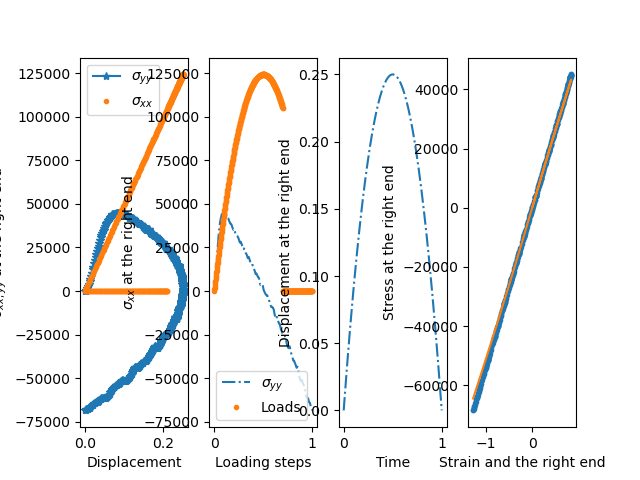

/tmp/ipykernel_42471/1787257599.py:21: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(results[:N_pt, 4], 2*float(mu)*float(sig0)*np.log(1+abs(results[:N_pt, 4])/float(sig0))\


In [18]:
import matplotlib.pyplot as plt
plt.subplot(1,4,1)
plt.plot(results[:, 0], results[:, 1], "-*")
plt.plot(results[:, 0], results[:, 3]*0.2*q_lim, ".")
plt.xlabel("Displacement")
plt.ylabel("$\sigma_{xx,yy}$ at the right end")
plt.legend(["$\sigma_{yy}$","$\sigma_{xx}$","Loads"])
plt.subplot(1,4,2)
plt.plot(results[:, 2], results[:, 1], "-.")
plt.plot(results[:, 2], results[:, 3]*0.2*q_lim, ".")
plt.xlabel("Loading steps")
plt.ylabel("$\sigma_{xx}$ at the right end")
plt.legend(["$\sigma_{yy}$","Loads"])
plt.subplot(1,4,3)
plt.plot(results[:, 2], results[:, 0], "-.")
plt.xlabel("Time")
plt.ylabel("Displacement at the right end")
plt.subplot(1,4,4)
N_pt = 1000;
plt.plot(results[:N_pt, 4], results[:N_pt, 1], ".-")
plt.plot(results[:N_pt, 4], 2*float(mu)*float(sig0)*np.log(1+abs(results[:N_pt, 4])/float(sig0))\
          *abs(results[:N_pt, 4])/results[:N_pt, 4], "-")
plt.xlabel("Strain and the right end")
plt.ylabel("Stress at the right end")
plt.show()

In [19]:
x_grid = np.linspace(0,1,N_mesh)
u_theo = x_grid/1*(1-x_grid**2/1)

<IPython.core.display.Javascript object>


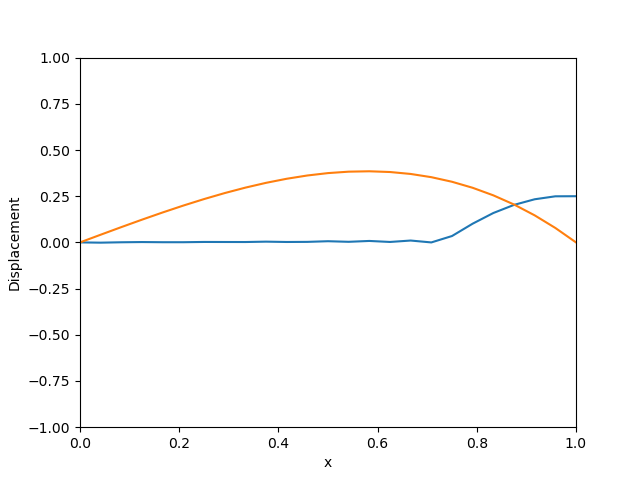

In [20]:
fig, ax = plt.subplots()

line1, = ax.plot([])
line2, = ax.plot([])

ax.set_xlim(0,1)
ax.set_ylim(-1e0,1e0)

ax.set_xlabel('x')
ax.set_ylabel('Displacement')

def animate(frame_num):
    # ax.clear()
    line1.set_data((np.linspace(0,1,N_mesh), results_1d[frame_num, :]))
    line2.set_data(x_grid,u_theo)
    return line1, line2

ani = FuncAnimation(fig, animate, frames=Nincr, interval=1)


plt.show()

